# Coolstore Evaluation

In this notebook, we evaluate the value proposition of Kai. Kai uses additional data from Konveyor Hub (solved examples), static code analysis as well as the rules themselves to augment an LLM prompt to get better quality responses. This is in contrast to using an LLM directly with little or no specific information in the prompts. 

We will work with Kai to provide fixes for issues identified in [Coolstore](https://github.com/konveyor-ecosystem/coolstore) app for different kinds of issues. The fixes for these issues involve varying levels of complexity. For each issue, we try to evaluate the responses under two conditions - with and without supplemental information from the analysis. In the supplemental analysis information, we will permute between text description about issues, previous solved examples, static code analysis information, etc.

Finally, we will compare how well Kai does against zero-shot prompts without much analysis information.

For evaluating the responses, we will use different approaches based on complexity of a fix in question. For easy fixes, we will use [evaluation.py](../../kai/evaluation.py) which uses edit distance. For more complex fixes, we will be using another LLM to evaluate based on a well defined criteria.

For comparing with expected output, we will use already modernized version of coolstore app for Quarkus which can be found in `quarkus` branch of the repo [here](https://github.com/konveyor-ecosystem/coolstore/tree/quarkus).

## Pre-requisites

To run snippets in this notebook, you first need to set up Kai's virtualenv in the [base dir](../../).

Activate the virtualenv and install the Jupyter kernel for it:

```sh
python -m ipykernel install --user --name=<your-venv-dir>
```

We also need an additional package for plotting charts which we will install in our environment:

```sh
pip install matplotlib
```

Once installed, you should be able to use your Kai venv for this notebook. In VsCode, this can be done in the upper right corner. 

Then, create a `.env` file in the [base dir](../../) that contains export commands to source your LLM access keys:

```sh
export GENAI_KEY=<your-ibm-key>
export OPENAI_API_KEY=<your-openai-key>
```

Note that both IBM and OpenAI keys are needed. 

Once `.env` file is ready, run the following cell to source the keys in notebook environment:

In [2]:
# make sure you set GENAI_KEY / OPENAI_KEY

%load_ext dotenv
%dotenv

Now, we will parse the analysis output to load the data into memory we need for the experiments. Continue running the cells in sequence one-by-one to advance.

In [28]:
# first we load incidents into memory and group by files for better access

import sys
sys.path.append('../../../kai')
from kai.models.report import Report

output_file = './analysis_output.yaml'
report = Report.load_report_from_file(output_file)
files = report.get_impacted_files()

# we filter out filepaths for dependencies
to_delete = []
for k in files: 
    if k.startswith('root/.m2'): to_delete.append(k)
for d in to_delete: del(files[d])

# printing file names and incidents in each file
for f in files: print(len(files[f]), f)

1 src/main/webapp/WEB-INF/web.xml
12 pom.xml
10 src/main/java/com/redhat/coolstore/model/Order.java
6 src/main/java/com/redhat/coolstore/model/OrderItem.java
5 src/main/webapp/WEB-INF/beans.xml
8 src/main/resources/META-INF/persistence.xml
6 src/main/java/com/redhat/coolstore/model/InventoryEntity.java
1 src/main/java/com/redhat/coolstore/model/ShoppingCart.java
6 src/main/java/com/redhat/coolstore/persistence/Resources.java
9 src/main/java/com/redhat/coolstore/rest/CartEndpoint.java
8 src/main/java/com/redhat/coolstore/rest/OrderEndpoint.java
3 src/main/java/com/redhat/coolstore/rest/ProductEndpoint.java
4 src/main/java/com/redhat/coolstore/rest/RestApplication.java
8 src/main/java/com/redhat/coolstore/service/CatalogService.java
2 src/main/java/com/redhat/coolstore/service/InventoryNotificationMDB.java
8 src/main/java/com/redhat/coolstore/service/OrderService.java
15 src/main/java/com/redhat/coolstore/service/OrderServiceMDB.java
3 src/main/java/com/redhat/coolstore/service/ProductSe

From the files displayed above, we will be focusing on following files in our experiments:

* src/main/java/com/redhat/coolstore/model/ShoppingCart.java
* src/main/java/com/redhat/coolstore/model/InventoryEntity.java
* src/main/java/com/redhat/coolstore/service/CatalogService.java
* src/main/java/com/redhat/coolstore/service/ShippingService.java
* src/main/java/com/redhat/coolstore/service/ShoppingCartOrderProcessor.java

These files appear in our demo example found [here](https://github.com/konveyor/kai/blob/main/docs/scenarios/demo.md)

Next up, we will clone the example app. The following cell will create a `data` directory to contain all the data we will generate when running experiments.

In [29]:
# now we will get our test data
import os
import errno
from git import Repo
import importlib

def ensure_dirs(dir):
    try:
        os.makedirs(dir)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

def clone_coolstore(branch: str, path: str):
    try:
        Repo.clone_from("https://github.com/konveyor-ecosystem/coolstore", 
            depth=1, single_branch=True, branch=branch, to_path=path)
    except Exception as e:
        if "already exists" not in str(e):
            print("fatal error cloning repo")
            sys.exit(1)

ensure_dirs("./data/apps/coolstore/")
clone_coolstore("quarkus", "./data/apps/coolstore/quarkus")
clone_coolstore("main", "./data/apps/coolstore/javaee")

Next, we will compile our analysis data as well as source code of affected files into a data structure for accessing later.

In [30]:
# now we will create data required for evaluation
from datetime import datetime
from kai.evaluation import BenchmarkExample, evaluate, BenchmarkResult
from kai.service.incident_store import Application

examples = {}
for f in files:
    original_content = ""
    expected_content = ""
    with open(f"./data/apps/coolstore/javaee/{f}", "r") as fl: original_content = fl.read()
    if os.path.exists(f"./data/apps/coolstore/quarkus/{f}"): 
        with open(f"./data/apps/coolstore/quarkus/{f}", "r") as fl: expected_content = fl.read()
    examples[f] = BenchmarkExample(
        application=Application(
            application_name="coolstore",
            current_branch="main",
            repo_uri_local="./data/apps/coolstore/javaee",
            generated_at=datetime.strptime("24/05/09 19:32:00", "%y/%m/%d %H:%M:%S"),
            repo_uri_origin="https://github.com/konveyor-ecosystem/coolstore",
            current_commit="aa"
        ),
        expected_file=expected_content,
        incidents=files[f],
        original_file=original_content,
        name=os.path.basename(f),
        report=report,
    )

We will create some config files (in-memory) which we need to run Kai.

In [31]:
from jinja2 import Template

CONFIG_BASE_PATH = "./data/configs/"
OUTPUT_BASE_PATH = "./data/outputs/"

ensure_dirs(CONFIG_BASE_PATH)
ensure_dirs(OUTPUT_BASE_PATH)

templ = Template("""
trace_enabled = true
demo_mode = false
log_dir = "$pwd/logs"
file_log_level = "debug"
log_level = "info"

[models]
provider = "{{ model_provider }}"
template = "{{ prompt_template }}"

[models.args]
{% if model_provider == "ChatOpenAI" %}
model = "{{ model_id }}"
{% else %}
model_id = "{{ model_id }}"
{% endif %}
{% if max_tokens != "" %}
parameters.max_new_tokens = "{{ max_tokens }}"
{% endif %}

[incident_store]
solution_detectors = "naive"
solution_producers = "text_only"

[incident_store.args]
provider = "postgresql"
host = "127.0.0.1"
database = "kai"
user = "kai"
password = "dog8code"
""")

# some shorthands we can use in our experiments for different models
META_LLAMA_13b = 'meta-llama-13b'
META_LLAMA_70b = 'meta-llama-70b'
MIXTRAL = 'mixtral'
IBM_GRANITE = 'ibm-granite'
GPT_4 = "gpt-4"
GPT_3 = "gpt-3"

all_models = [
    META_LLAMA_13b,
    META_LLAMA_70b,
    IBM_GRANITE,
    MIXTRAL,
    GPT_3,
    GPT_4
]

# model_provider: { model_id: {parameter: val}}
models = {
    "ChatIBMGenAI": {
        "meta-llama/llama-3-70b-instruct": {"max_tokens": "2048", "key": META_LLAMA_70b},
        "meta-llama/llama-2-13b-chat": {"max_tokens": "1536", "key": META_LLAMA_13b},
        "mistralai/mixtral-8x7b-instruct-v01": {"key": MIXTRAL},
        "ibm/granite-13b-chat-v2": {"key": IBM_GRANITE},
    },
    "ChatOpenAI": {
        "gpt-3.5-turbo": {"key": GPT_3},
        "gpt-4": {"key": GPT_4},
    },
}

configs = {}

# create configs for all models with different parameters 
# we will use these as needed in our experiments
for model_provider, model_ids in models.items():
    for model_id, parameters in model_ids.items():
        configs[parameters.get("key", "")] = Template(templ.render(
            model_provider = model_provider,
            model_id = model_id,
            max_tokens = parameters.get("max_tokens", ""),
            prompt_template = "{{ prompt_template }}"
        ))

The following cell contains some common code we will be using for experiments. There is no output for the cell, just run it before moving forward.

In [32]:
# this is common code we will use to evaluate response of LLM for one example
import json
import signal
import requests
import threading
import subprocess
from time import sleep
from kai.models.kai_config import KaiConfig
from kai.routes.get_incident_solutions_for_file import (
    PostGetIncidentSolutionsForFileParams,
)

# helper function to send requests to Kai service
def generate_fix(log: any, params: PostGetIncidentSolutionsForFileParams) -> dict:
    retries_left = 6
    for i in range(retries_left):
        try:
            headers = {"Content-type": "application/json", "Accept": "text/plain"}
            response = requests.post(
                "http://0.0.0.0:8080/get_incident_solutions_for_file",
                data=params.model_dump_json(),
                headers=headers,
                timeout=3600,
            )
            if response.status_code == 200:
                result = response.json()
                if isinstance(result, str):
                    return json.loads(result)
                elif isinstance(result, dict):
                    return result
                else:
                    return {}
            else:
                log.write(f"[{params.file_name}] Received status code {response.status_code}")
        except requests.exceptions.RequestException as e:
            log.write(f"[{params.file_name}] Received exception from Kai server: {e}")
        log.write(f"[{params.file_name}] Failed to get a '200' response from the server.  Retrying {retries_left-i} more times")
    raise(Exception(f"[{params.file_name}] Failed to get a '200' response from the server.  Parameters = {params}"))


# write a Kai config to a known location 
def ensure_config(model_key: str, experiment_key: str, prompt_template: str) -> tuple[str, str]:
    ensure_dirs(f"{CONFIG_BASE_PATH}{experiment_key}")
    config_path = f"{CONFIG_BASE_PATH}{experiment_key}/{model_key}.toml"
    config = configs[model_key].render(prompt_template=prompt_template)
    with open(config_path, "w+") as f: f.write(config)
    config_parsed = KaiConfig.model_validate_filepath(config_path)
    return config_path, config_parsed

# run Kai service, this is used when we use Kai service instead of evaluate.py for generating fixes
def ensure_kai_service(output_path: str) -> tuple[list, list]:
    processes = []
    def run_command(cmd: str, stdout: any): 
        p = subprocess.Popen(cmd, shell=True, cwd="../../", 
            env=os.environ.copy(), stdout=stdout, stderr=stdout)
        processes.append(p)
        p.wait()
    ensure_dirs(f"{output_path}")
    postgres_log = open(f"{output_path}/postgres.log", "w+")
    db_thread  = threading.Thread(target=run_command, args=("DROP_TABLES=true POSTGRES_RUN_ARGS=--rm make run-postgres", postgres_log, ))
    kai_log = open(f"{output_path}/kai.log", "w+")
    kai_thread = threading.Thread(target=run_command, args=("make run-server", kai_log, ))
    db_thread.start()
    data_load_log = open(f"{output_path}/data_load.log", "w+")
    subprocess.run(["make", "load-data"], cwd="../../", stdout=data_load_log, stderr=data_load_log)
    kai_thread.start()
    return processes, [kai_log, postgres_log, data_load_log]

# helper function to kill processes gracefully, needed to clean up Kai service and db
def kill(processes: list):
    for p in processes:
        p.send_signal(signal.SIGINT)
        p.send_signal(signal.SIGTERM)

# this function runs "evaluate" function from evaluation.py and compares LLM responses with expected output to get edit distance
def run_evaluate_for_example(model_key: str, experiment_key: str, prompt_template: str, example: BenchmarkExample):
    config_path, config_parsed = ensure_config(model_key, experiment_key, prompt_template)
    full_response = evaluate(configs={config_path: config_parsed}, examples={example.name: example})
    response = full_response[(example.name, config_path)]
    output_path = f"{OUTPUT_BASE_PATH}/using_evaluation/{experiment_key}/{model_key}"
    ensure_dirs(output_path)
    with open(f"{output_path}/llm_response", "w+") as f: f.write(response.llm_result)
    with open(f"{output_path}/edit_distance", "w+") as f: f.write(f"{response.similarity}")
    with open(f"{output_path}/updated_file", "w+") as f: f.write(f"{response.updated_file}")

# this function sends example in a query to Kai service to get LLM response
def run_kai_generate_fix(model_key: str, experiment_key: str, prompt_template: str, example: BenchmarkExample, solved_examples: bool = False):
    output_path = f"{OUTPUT_BASE_PATH}/using_kai/{experiment_key}/{model_key}"
    ensure_dirs(output_path)
    runner_log = open(f"{output_path}/runner.log", "w+")
    config_path, config_parsed = ensure_config(model_key, experiment_key, os.path.basename(prompt_template))
    subprocess.run(['cp', f'../../kai/config.toml', f'../../kai/config.toml.temp'])
    subprocess.run(['cp', f'{config_path}', f'../../kai/config.toml'])
    subprocess.run(['cp', f'{prompt_template}', f'../../kai/data/templates/'])
    processes, logs = ensure_kai_service(output_path=output_path)
    # sleep is needed to let Kai server come up
    sleep(10)
    try:
        params = PostGetIncidentSolutionsForFileParams(
            application_name=example.application.application_name,
            file_contents=example.original_file,
            file_name=example.name,
            include_llm_results=False,
            incidents=example.incidents,
        )
        response = generate_fix(runner_log, params)
        if not response: 
            raise(f"failed to parse response")
        with open(f"{output_path}/llm_reasoning", "w+") as f: f.write(response.get('total_reasoning', [''])[0])
        with open(f"{output_path}/prompt", "w+") as f: f.write(response.get('used_prompts', [''])[0])
        with open(f"{output_path}/updated_file", "w+") as f: f.write(response.get('updated_file', ['']))
    except Exception as e:
        runner_log.write(f"failed to generate fix {e}")
    finally:
        # clean up
        subprocess.run(['rm', f'../../kai/data/templates/{os.path.basename(prompt_template)}'])
        subprocess.run(['mv', f'../../kai/config.toml.temp', f'../../kai/config.toml'])
        kill(processes)
        # sleep is needed to gracefully shutdown
        sleep(10)
        runner_log.close()
        for log in logs: log.close()
    pass

## Zero Shot with No Analysis Information

In this section, we run our first experiment. The prompt we use will have NO analysis information in it. We will ask LLM to simply generate a fixed file without telling it any more information. This is our baseline. We will run this with different models. 

### Easy example

We will run Kai for a very simple fix first. This file only contains a fix that requires changing an import from `javax` to `jakarta`.

We will run the following cell to run the easy example with different models. The outputs of this experiment will be generated in `./data/outputs/using_kai/zero_shot_easy/` directory for each model.

_Note we have seen sometimes it takes more than one try to get output from a model, especially with mixtral_

In [33]:
# this file only contains fixes that require changing imports...an easy example
example_zero_shot_easy = examples['src/main/java/com/redhat/coolstore/model/ShoppingCart.java']

# run kai-fix for all models
for model in all_models:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "zero_shot_easy", "./templates/zero_shot/example1.jinja", example_zero_shot_easy)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/zero_shot_easy/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/zero_shot_easy/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/zero_shot_easy/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/zero_shot_easy/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/zero_shot_easy/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/zero_shot_easy/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/zero_shot_easy/gpt-4


#### Evaluating LLM responses

Although this fix is pretty easy to make (replace an import statement), evaluating it using edit distance has been a challenge. Because, LLMs are not predictable and they may sometimes fix more things than needed, not fix anything at all and/or introduce new issues. For instance, in this file, the only change that needs to happen is replace the `javax` import with `jakarta`. If the LLM doesn't fix this issue at all, the edit distance of the LLM response with the expected file will be quite low (where low is better) because only change in the file would be that `javax` string. However, that doesn't really help us in determining whether the issue was fixed. Also, this file contains many functions. If the LLM changes function signatures etc resulting in a bigger change, the edit distance will be higher. But that doesn't mean those function definitions are wrong. They can still be valid. In none of these scenarios, we can objectively tell whether the file is actually compatible with Quarkus. 

For these reasons, we use another smarter LLM to evaluate responses. In that, we will ask the LLM to rate the migrated file (updated file returned by Kai) based on a well defined criteria. There will be 3 main metrics in the criteria, each having a rating on a scale of 0 to 5. A higher rating in all metrics is a good sign.

The metrics are:

1. Is LLM fixing the things that need to be fixed?

This metric evaluates whether LLM is doing changes than are required. We want the issues that we originally pointed out fixed in the final output. Also, we want specific changes, not unnecessary changes.

2. Is the Java file generally syntactically correct? 

With this metric, we focus on general syntactical correctness. Additionally, we specifically evaluate whether all imports are correct, function signatures are correct, etc.

3. Is the final file suitable for Quarkus? Are there more changes needed to be done?

Here, we evaluate based on whether the final file is compatible with Quarkus. We also see if there were any new issues introduced in the file.

We don't care about all these metrics equally, so we take an weighted average with weights being 0.6, 0.3, 0.1 from top to bottom.

The assumption is that the LLM we use for evaluation is inherently knowledgeable about Quarkus and will be accurate enough to give us a good high level picture of the quality of responses. We will use `gpt-4` in this case. Find our evaluation prompt [here](./templates/evaluation.jinja). 

We understand that this is not a perfect way to evaluate. But, we can improve on evaluation itself. We are not including any examples of evaluation in our prompt right now. We can include some relevant examples pertaining to issues in the file to get better evaluation results.

With that said, we are not interested in the exact ratings in evaluation. The goal is just to get an insight into how well a LLM performs when it is given additional information from incidents. That is where the magic of Kai happens. And conclusion we are looking for is whether that magic is really useful. So we will be only looking at evaluation results in relative scale.

To run the evaluation, you will require _OPENAI_API_KEY_, make sure it's present in your '.env' file and you have run the very first code cell in this notebook after adding it. 

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from langchain.chat_models import ChatOpenAI
from langchain.schema import StrOutputParser
from jinja2 import Environment, FileSystemLoader

evaluation_criteria = {
    0: 'Issue Fixed?',
    1: 'General syntax correct?',
    2: 'Suitable for Quarkus?',
}

template_env = Environment(
    loader=FileSystemLoader(searchpath="./templates/"))

# function to evaluate updated file generated with kai using gpt-4 
def evaluate_with_gpt(key: str, example: BenchmarkExample, updated_file: str) -> str:    
    t = template_env.get_template("evaluate.jinja").render(
        incidents=example.incidents, original_file=example.original_file, 
        updated_file=updated_file)
    llm = ChatOpenAI(model_name="gpt-4")
    output = llm.invoke(t)
    return output.content

# parses evaluation output
def parse_evaluation_output(output: str) -> tuple[list[int], list[str]]:
    ratings = []
    reasoning = []
    for idx, line in enumerate(output.strip('\n').strip('```').replace("\n\n", "\n").split("\n")):
        if idx % 2 == 0:
            ratings.append(float(line))
        else:
            reasoning.append(line)
    return ratings, reasoning

def plot_evaluation_score(data: dict):
    keys = list(data.keys())
    values = np.array(list(data.values()))
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(keys, values)
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
    ax.set_ylim(0, 5)
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Evaluation Score by Model')
    fig.tight_layout()
    plt.show()

def plot_multibar_chart(data: list[tuple[dict, str]]):
    labels = [label for _, label in data]
    models = list(data[0][0].keys())
    x = np.arange(len(models))
    width = 0.2
    fig, ax = plt.subplots(figsize=(12, 6))
    for i, (results, label) in enumerate(data):
        values = [results[model] for model in models]
        ax.bar(x + i*width, values, width, label=label)
    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Evaluation Scores by Model')
    ax.set_xticks(x + width / len(data) * (len(data) - 1))
    ax.set_xticklabels(models)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# given raw evaluation output from models, plots the chart and prints reasoning 
def plot_chart_and_print_reasoning(eval_output: dict):
    data = {}
    for model in all_models:
        data[model] = parse_evaluation_output(eval_output[model])
    plot_evaluation_score({k: np.average(v[0], weights=[0.6, 0.3, 0.1]) for k, v in data.items()})
    for model in all_models:
        print(f"{'* '}{model}")
        for idx, reasoning in enumerate(data[model][1]):
            print(f"\t{idx+1}. {reasoning}")

# given multiple eval outputs, plots a chart side-by-side for comparison
def plot_multibar_chart_from_eval_outputs(eval_outputs: list[tuple[dict, str]]):
    data_list = []
    for eval_output, label in eval_outputs:
        data_per_model = {}
        for model in all_models:
            data_per_model[model] = parse_evaluation_output(eval_output[model])
        data_list.append(({k: np.average(v[0], weights=[0.6, 0.3, 0.1]) for k, v in data_per_model.items()}, label))
    plot_multibar_chart(data_list)


In [35]:
zero_shot_easy_eval_output = {}
for model in all_models:
    # get updated file
    base_output_path = "./data/outputs/using_kai/zero_shot_easy"
    updated_content = ""
    with open(f"{base_output_path}/{model}/updated_file", "r") as f: updated_content = f.read()    
    zero_shot_easy_eval_output[model] = evaluate_with_gpt(model, example_zero_shot_easy, updated_content)

Now that we have data from our first experiment, we will plot a bar chart. And also print reasoning behind each score our evaluation produced for different models.

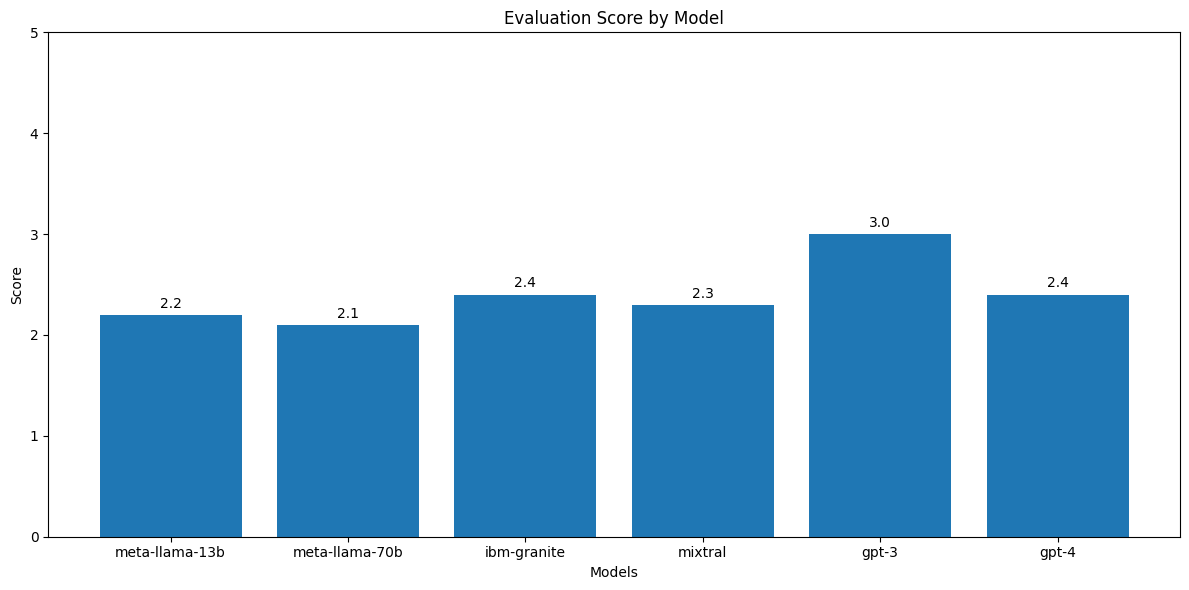

* meta-llama-13b
	1. The issue identified in the JavaEE file was not fixed in the updated file. The import statement for `javax.enterprise` was not replaced with `jakarta.enterprise`.
	2. The updated file is not syntactically valid. The Serializable interface is not imported, which will cause a compilation error.
	3. The updated file seems to be compatible with Quarkus. The @RegisterForReflection annotation is used correctly. However, since the Serializable interface was not imported, it's uncertain if the file will work successfully with Quarkus without further modifications.
* meta-llama-70b
	1. The issue pointed out in the original JavaEE file is not fixed in the updated file. The `javax.enterprise` import statement was supposed to be replaced with `jakarta.enterprise`, however, it was completely removed.
	2. The updated file is syntactically valid. No issues that could lead to a compilation error are identified.
	3. The updated file is not suitable for Quarkus. The `javax.enterpris

In [36]:

plot_chart_and_print_reasoning(zero_shot_easy_eval_output)

All of the files generated by different models used in above evaluation can be found under [results/zero_shot_easy](./results/zero_shot_easy/) directory. If you look at the reasoning our evaluation model produced for each output, and compare that with the actual generated file, we can see that the scores rightly (somewhat) reflect the idea of "accuracy" of a certain fix. One important point to note here is that since this file only contained one issue, the evaluation output is pretty much binary (remember, we have the highest weight on metric 1 i.e. whether the issue is fixed or not). This won't be the case for more harder cases further ahead.

Note that absolute rating numbers don't matter much. We are more interested in looking at how a model does relatively in different scenarios. Finally, we will be looking at the trend of how things improved as Kai added more and more contextual information to the prompt.

### Medium example

Now we will run the same experiment with a harder example. In this file, there are more than one incidents present. Some of these incidents contain changes to imports as well as require replacing some annotations. See the full change [here](https://github.com/konveyor/kai/blob/main/docs/scenarios/demo.md#ejb-remote)

In [37]:
# this file only contains fixes that require changing imports...an easy example
example_zero_shot_med = examples['src/main/java/com/redhat/coolstore/service/ShippingService.java']

# run kai-fix for all models
for model in all_models:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "zero_shot_med", "./templates/zero_shot/example1.jinja", example_zero_shot_med)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/zero_shot_med/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/zero_shot_med/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/zero_shot_med/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/zero_shot_med/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/zero_shot_med/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/zero_shot_med/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/zero_shot_med/gpt-4


The output for above experiment can be found under [data/outputs/using_kai/zero_shot_hard](./data/outputs/using_kai/zero_shot_hard) directory. Now we will run the evaluation.

In [38]:
zero_shot_med_eval_output = {}
for model in all_models:
    # get updated file
    base_output_path = "./data/outputs/using_kai/zero_shot_med"
    updated_content = ""
    with open(f"{base_output_path}/{model}/updated_file", "r") as f: updated_content = f.read()    
    zero_shot_med_eval_output[model] = evaluate_with_gpt(model, example_zero_shot_med, updated_content)

Now we plot the chart.

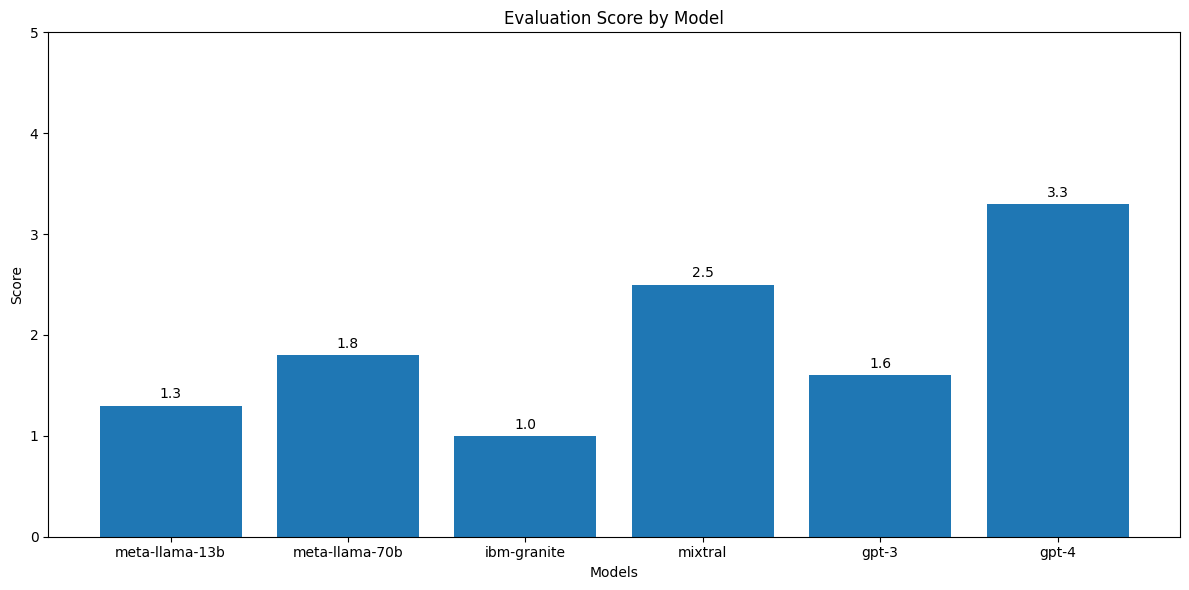

* meta-llama-13b
	1. The file has not replaced the `javax.ejb` import statement with `jakarta.ejb`. It has removed the `@Stateless` annotation but has not replaced it with `@ApplicationScoped`. The `@Remote` annotation has been removed, but it has not been replaced with a `@jakarta.ws.rs.Path("<endpoint>")` annotation. The public method `calculateShipping` has not been annotated with `@jakarta.ws.rs.GET` or `@jakarta.ws.rs.POST`.
	2. The file does not import the `ShoppingCart` class, which is used in the `ShippingService` class. It uses `@Inject` to initialize `ShoppingCart` but `@Inject` is not imported. It also does not import the `@Bean` annotation which is used in the class.
	3. The file does not use the `jakarta.ws.rs.Path("<endpoint>")` annotation and does not annotate the public methods with `@jakarta.ws.rs.GET` or `@jakarta.ws.rs.POST`. Therefore, it cannot be accessed as a REST service. The `calculateShipping` method also does not include the `@jakarta.ws.rs.QueryParam("<param

In [39]:
# actual evaluation cell and the chart plotting is intentionally kept separate
# to avoid repeated LLM calls
plot_chart_and_print_reasoning(zero_shot_med_eval_output)

As compared to the "easy" example we saw earlier, these results show some promise for llama-13b model. For the easy example, it was scored "0" whereas for a harder example, it is scored as "1". But one important point to consider is that for one fix the evaluation score was merely binary either fixed or not. But for a harder case, we see that evaluator is giving some score for "partial" fixes. 

> Nevertheless, at a high level, we can say that zero shot prompts become less useful as the file becomes more complex to fix.

### Hard example

Here, we use even harder example of replacing Message Driven Beans. In addition to changing imports and APIs, the change involves removing some code and replacing it with a compatible API. See the full change [here](https://github.com/konveyor/kai/blob/main/docs/scenarios/demo.md#message-driven-beanmdb).

In [40]:
example_zero_shot_hard = examples['src/main/java/com/redhat/coolstore/service/ShoppingCartOrderProcessor.java']

# run kai-fix for all models
for model in all_models:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "zero_shot_hard", "./templates/zero_shot/example1.jinja", example_zero_shot_hard)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/zero_shot_hard/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/zero_shot_hard/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/zero_shot_hard/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/zero_shot_hard/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/zero_shot_hard/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/zero_shot_hard/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/zero_shot_hard/gpt-4


In [133]:
zero_shot_hard_eval_output = {}
for model in all_models:
    # get updated file
    base_output_path = "./data/outputs/using_kai/zero_shot_hard"
    updated_content = ""
    with open(f"{base_output_path}/{model}/updated_file", "r") as f: updated_content = f.read()    
    zero_shot_hard_eval_output[model] = evaluate_with_gpt(model, example_zero_shot_hard, updated_content)

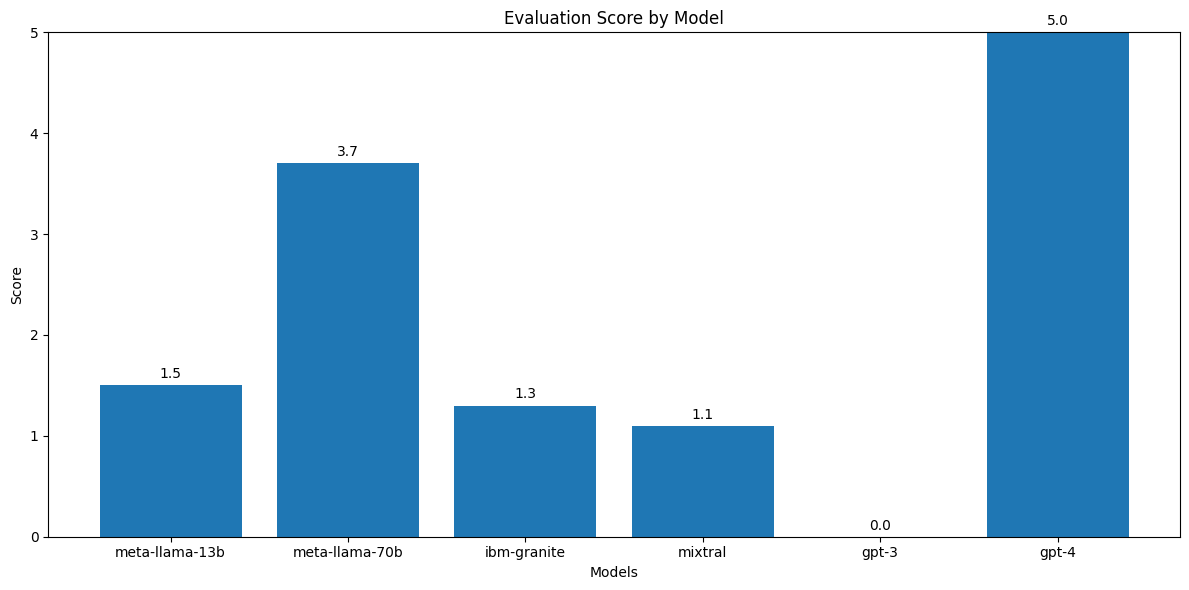

* meta-llama-13b
	1. The updated file has fixed only 1 out of the 10 issues identified in the JavaEE file. The @Stateless annotation has been removed, however it has not been replaced with a scope like @ApplicationScoped as suggested in incident 5.
	2. The updated file seems to be syntactically valid. However, the MessageProducer and Topic classes are not imported in the updated file. Also, the @QuarkusBean annotation does not exist; it should be replaced with a CDI scope annotation like @ApplicationScoped.
	3. The updated file is not suitable for Quarkus. The @Resource annotation should be replaced with @Inject and @Channel annotations as per incident 6 and 7. The references to JavaEE/JakartaEE JMS elements have not been replaced with their Quarkus SmallRye/Microprofile equivalents as per incident 8 and 9. Moreover, the @QuarkusBean annotation does not exist in Quarkus.
* meta-llama-70b
	1. Out of the 10 issues identified, 5 were fixed in the updated file: incidents 5, 6, 7, 8, and 9.

In [134]:
plot_chart_and_print_reasoning(zero_shot_hard_eval_output)

## Zero Shot with analysis information

In this section, we run kai fix with a modified prompt. It will contain information about incidents in the file which will help pinpoint the issues in the file. We will run the exact same experiments we ran in the previous section.

### Easy example

This example only contains one issue which requires replacing an import. Find the prompt used in this example [here](./templates/zero_shot/with_analysis_info.jinja)

In [41]:
# this file only contains fixes that require changing imports...an easy example
example_zero_shot_easy_with_info = examples['src/main/java/com/redhat/coolstore/model/ShoppingCart.java']

# run kai-fix for all models
for model in all_models:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "zero_shot_easy_with_info", "./templates/zero_shot/with_analysis_info.jinja", example_zero_shot_easy_with_info)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/zero_shot_easy_with_info/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/zero_shot_easy_with_info/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/zero_shot_easy_with_info/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/zero_shot_easy_with_info/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/zero_shot_easy_with_info/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/zero_shot_easy_with_info/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/zero_shot_easy_with_info/gpt-4


Now let's evaluate the responses and plot the charts.

In [42]:
zero_shot_easy_with_info_eval_output = {}
for model in all_models:
    # get updated file
    base_output_path = "./data/outputs/using_kai/zero_shot_easy_with_info"
    updated_content = ""
    with open(f"{base_output_path}/{model}/updated_file", "r") as f: updated_content = f.read()    
    zero_shot_easy_with_info_eval_output[model] = evaluate_with_gpt(model, example_zero_shot_easy_with_info, updated_content)

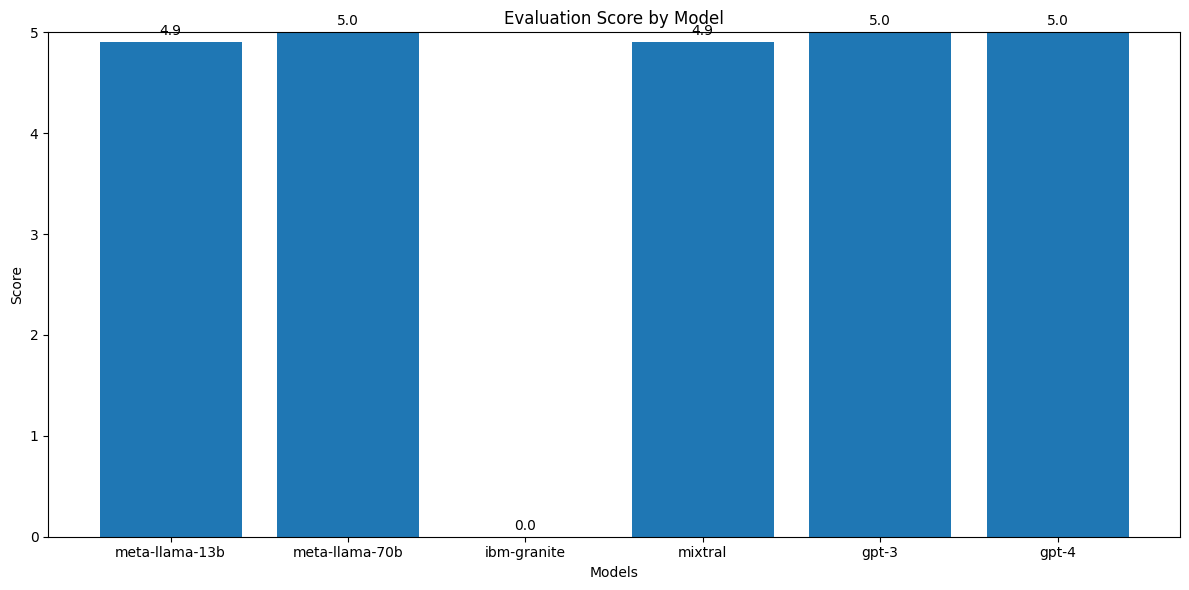

* meta-llama-13b
	1. The issue identified in the JavaEE file is correctly fixed in the Quarkus file, the `javax.enterprise` import has been correctly replaced with `jakarta.enterprise`.
	2. The updated file does not contain any syntactical issues. All classes, interfaces, annotations, etc used in the file are correctly imported.
	3. The Quarkus file has been made compatible with Quarkus. However, the `Serializable` interface is not imported in the Quarkus file. This won't cause a compilation error as `Serializable` is a built-in Java interface, but it's considered a good practice to import all used interfaces and classes explicitly.
* meta-llama-70b
	1. The issue regarding the import statement is fixed. The `javax.enterprise` import statement is correctly replaced with `jakarta.enterprise`.
	2. The updated file doesn't have any syntax errors. All the classes, interfaces, annotations are correctly imported and used.
	3. The updated file is compatible with Quarkus. There are no issues id

In [43]:
plot_chart_and_print_reasoning(zero_shot_easy_with_info_eval_output)

### Medium example

Now we use a relatively harder example to evaluate responses. This is the same example we used earlier with zero shot and NO analysis information in the prompt. 

In [44]:
example_zero_shot_med_with_info = examples['src/main/java/com/redhat/coolstore/service/ShippingService.java']

# run kai-fix for all models
for model in all_models:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "zero_shot_med_with_info", "./templates/zero_shot/with_analysis_info.jinja", example_zero_shot_med_with_info)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/zero_shot_med_with_info/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/zero_shot_med_with_info/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/zero_shot_med_with_info/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/zero_shot_med_with_info/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/zero_shot_med_with_info/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/zero_shot_med_with_info/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/zero_shot_med_with_info/gpt-4


Now we evaluate and plot the charts.

In [47]:
zero_shot_med_with_info_eval_output = {}
for model in all_models:
    # get updated file
    base_output_path = "./data/outputs/using_kai/zero_shot_med_with_info"
    updated_content = ""
    with open(f"{base_output_path}/{model}/updated_file", "r") as f: updated_content = f.read()    
    zero_shot_med_with_info_eval_output[model] = evaluate_with_gpt(model, example_zero_shot_med_with_info, updated_content)

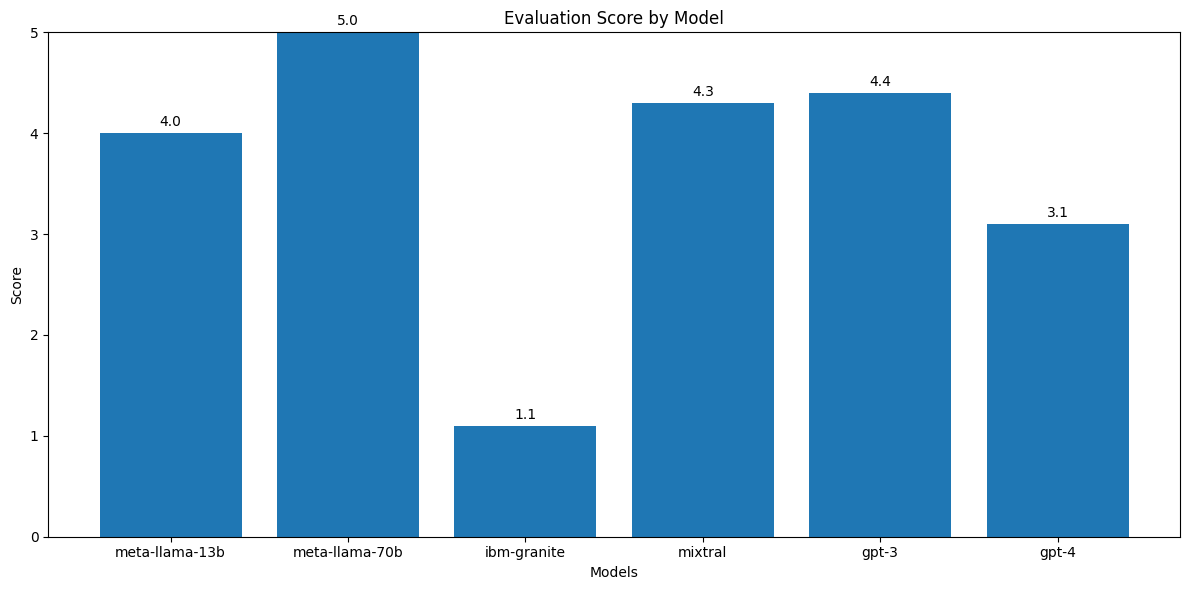

* meta-llama-13b
	1. All but one issue have been fixed. The import statements for `javax.ejb` haven't been replaced with `jakarta.ejb`.
	2. The updated file is syntactically valid and there do not seem to be any compilation issues, but the import statements for `javax.ejb` are still present from the original file and not used, which can be removed.
	3. The updated file is mostly compatible with Quarkus. However, the import statements for `javax.ejb`, although not used, are still present in the updated file which should be removed.
* meta-llama-70b
	1. All of the identified issues have been fixed in the updated file. The `javax.ejb` import statements were replaced with `jakarta.ejb`. The `@Stateless` and `@Remote` annotations were replaced with `@ApplicationScoped` and `@Path("/shipping")` respectively. All public methods were annotated with `@GET` and `@Path` annotations and `@QueryParam` was added to the method parameters.
	2. The updated file is syntactically valid. All classes, inte

In [48]:
plot_chart_and_print_reasoning(zero_shot_med_with_info_eval_output)

# Few Shot (Diff Only)

In this section, we will run the same examples but this time we will include solved examples in our prompts. Kai already has this functionality built in. We will make use of that. Note that we will be using the diff only strategy for providing LLMs with solved examples.

## Easy example

We use the same example from the previous experiments. With analysis information alone, all LLMs seem to be performing well for this example. The real thing we should be looking for here is - whether the worst performing models from previous experiments show any improvements.

In [53]:
# this file only contains fixes that require changing imports...an easy example
example_few_shot_easy = examples['src/main/java/com/redhat/coolstore/model/ShoppingCart.java']

# run kai-fix for all models
for model in [IBM_GRANITE]:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "few_shot_easy", "./templates/few_shot/few_shot_easy.jinja", example_few_shot_easy)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/few_shot_easy/{model}")

generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/few_shot_easy/ibm-granite


Now we will evaluate the responses.

In [54]:
few_shot_easy_eval_output = {}
for model in all_models:
    # get updated file
    base_output_path = "./data/outputs/using_kai/few_shot_easy"
    updated_content = ""
    with open(f"{base_output_path}/{model}/updated_file", "r") as f: updated_content = f.read()    
    few_shot_easy_eval_output[model] = evaluate_with_gpt(model, example_few_shot_easy, updated_content)

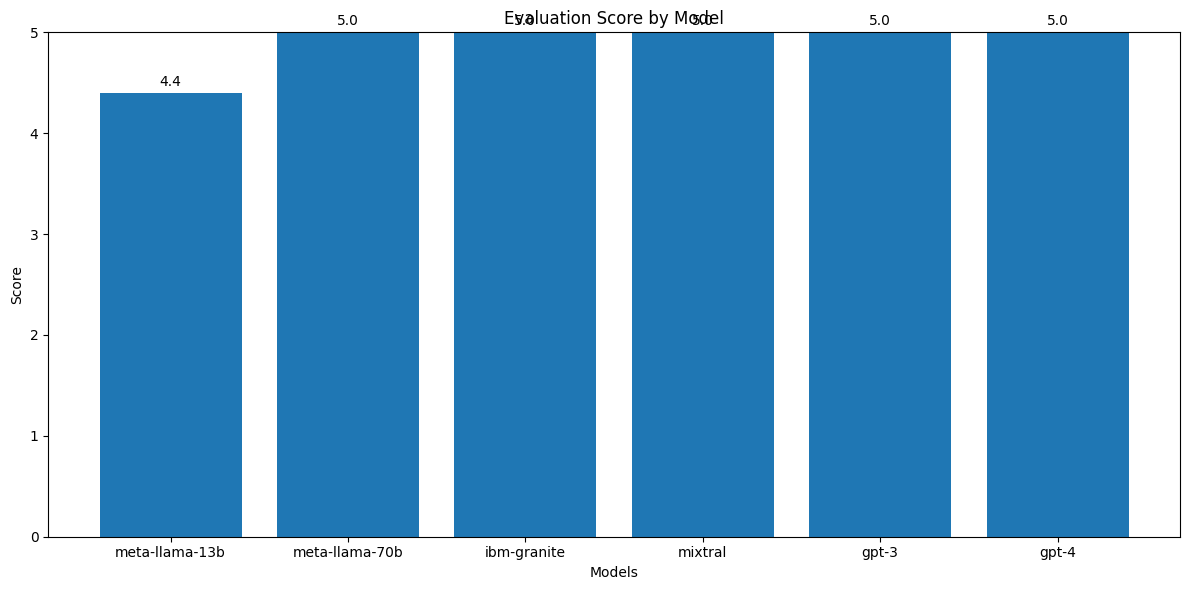

* meta-llama-13b
	1. The identified issue in the original JavaEE file has been correctly fixed in the migrated Quarkus file. The `javax.enterprise` import statement has been replaced with `jakarta.enterprise`.
	2. Though the file is mostly syntactically valid, it contains duplicate import statements for `jakarta.enterprise.context.Dependent`, which is unnecessary and can cause confusion.
	3. The file appears to be compatible with Quarkus since the identified issue that was making it incompatible has been corrected. No new issues were introduced in the updated file.
* meta-llama-70b
	1. The issue identified in the original JavaEE file was fixed in the updated file. The `javax.enterprise` import statement was replaced with `jakarta.enterprise`.
	2. There are no syntactical issues in the updated file. All classes, interfaces, and annotations are imported correctly and the file can be compiled without any errors.
	3. The updated file is compatible with Quarkus. There are no issues identifi

In [55]:
plot_chart_and_print_reasoning(few_shot_easy_eval_output)

# Comparing evaluation outputs for different scenarios

In this section, we compare evaluation outputs we obtained from various different scenarios in previous sections. 

## Easy Example

For the easy example, we looked at doing a simple fix with Kai which involved updating a single import statement.

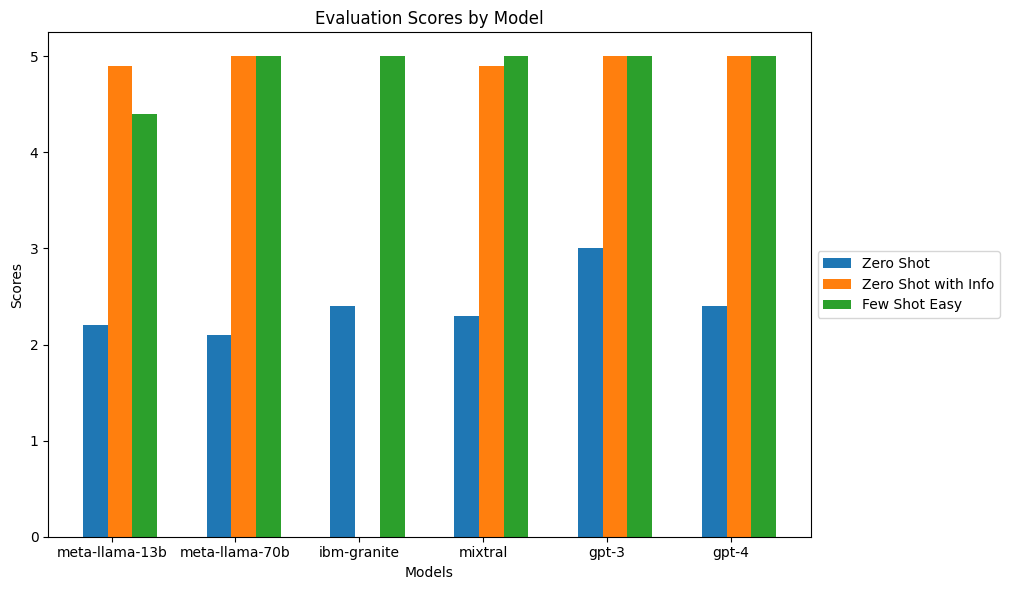

In [89]:
plot_multibar_chart_from_eval_outputs([
    (zero_shot_easy_eval_output, "Zero Shot"), 
    (zero_shot_easy_with_info_eval_output, "Zero Shot with Info"), 
    (few_shot_easy_eval_output, "Few Shot Easy")])

## Medium Example


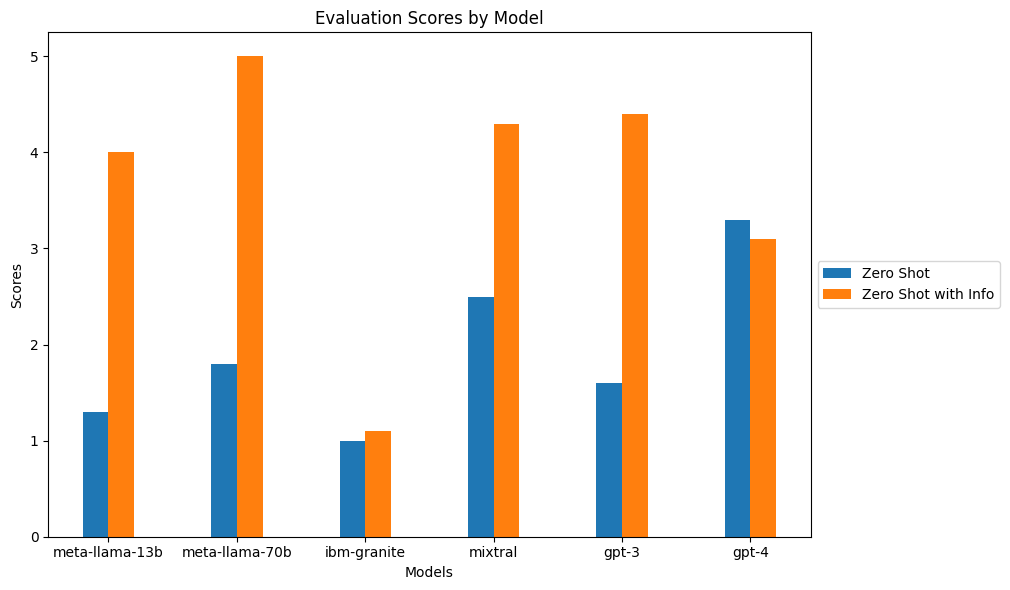

In [91]:

plot_multibar_chart_from_eval_outputs([
    (zero_shot_med_eval_output, "Zero Shot"), 
    (zero_shot_med_with_info_eval_output, "Zero Shot with Info")]) 